# This script implements the use of various classifiers to predict music genre.  Specifically, four types of electronic music are being classified: breakbeat, drum and bass, house, and hip-hop.  This script also attempts to classify three sub-genres of drum and bass: minimal, neurofunk, and jungle.  The data used in these classfiers were extracted from tracks using the script called xxxx.

In [35]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA

from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from itertools import cycle

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')

# Functions to be used in notebook

In [36]:
def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(15, 15))
    for i, c, label in zip(target_ids, colors, target_names):
        print(i, '', target_names)
        plt.scatter(data[target == target_names[i], 0], data[target == target_names[i], 1], c=c, label=label)
    plt.legend(fontsize=20)
    plt.show()


def save_dataframe_as_pickle(frame_to_save, save_name):
    with open(save_name, 'wb') as f:
        pickle.dump(frame_to_save, f)


def open_dataframe_pickle(name_of_pickle):
    with open(name_of_pickle, 'rb') as f:
        df_from_pickle = pickle.load(f)
    return df_from_pickle


def train_score(classifier, Xtrain, Xtest, ytrain, ytest):
    train_acc = classifier.score(Xtrain, ytrain)
    test_acc = classifier.score(Xtest, ytest)
    print("Training Data Accuracy: %0.2f" % (train_acc))
    print("Test Data Accuracy:     %0.2f" % (test_acc))
    ypred = classifier.predict(Xtest)
    conf = confusion_matrix(ytest, ypred)
    precision = (conf[0, 0] / (conf[0, 0] + conf[1, 0]))
    recall = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
    f1_score = 2 * ((precision * recall)/(precision + recall))
    print("Precision:              %0.2f" % precision)
    print("Recall:                 %0.2f" % recall)
    print("F1 Score:                 %0.2f" % f1_score)
    print('\n')


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=None):
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    plt.tight_layout()
    # plt.set_xticklabels(labels)
    # plt.yticks(labels)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()


# First, I begin with genre classification

In [37]:
# import data
savefile_master_ZCR_final = 'tracks_set_2_ZCR_final.pickle'
savefile_master_RMS_final = 'tracks_set_2_RMS_final.pickle'
savefile_master_SPEC_CENTR_final = 'tracks_set_2_SPEC_CENTR_final.pickle'
savefile_master_SPEC_ROLL_final = 'tracks_set_2_SPEC_ROLL_final.pickle'
savefile_master_SPEC_FLUX_final = 'tracks_set_2_SPEC_FLUX_final.pickle'
savefile_master_MFCC_final = 'tracks_set_2_MFCC_final.pickle'
savefile_master_RYTHM_final = 'tracks_set_2_RYTHM_final.pickle'

# create the various empty dataframes and dump data into them from file.
df = pd.DataFrame()
df_info = pd.DataFrame()
df_ZCR = pd.DataFrame()
df_RMS = pd.DataFrame()
df_SPEC_CENTR = pd.DataFrame()
df_SPEC_ROLL = pd.DataFrame()
df_SPEC_FLUX = pd.DataFrame()
df_MFCC = pd.DataFrame()
df_RYTHM = pd.DataFrame()


data_temp = open_dataframe_pickle(savefile_master_ZCR_final)

df_info['labels'] = data_temp['label']
df['labels'] = data_temp['label']
df_info['tracks'] = data_temp['path']
df_info['sample_rate'] = data_temp['sample_rate']

df_ZCR['ZCR'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_RMS_final)
df_RMS['RMS'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_SPEC_CENTR_final)
df_SPEC_CENTR['SPEC_CENTR'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_SPEC_ROLL_final)
df_SPEC_ROLL['SPEC_ROLL'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_SPEC_FLUX_final)
df_SPEC_FLUX['SPEC_FLUX'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_MFCC_final)
df_MFCC['MFCCs_mean_1'] = data_temp['MFCCs_mean_1']
df_MFCC['MFCCs_std_1'] = data_temp['MFCCs_std_1']
df_MFCC['mspec_mean_1'] = data_temp['mspec_mean_1']
df_MFCC['mspec_std_1'] = data_temp['mspec_std_1']
df_MFCC['MFCCs_mean_2'] = data_temp['MFCCs_mean_2']
df_MFCC['MFCCs_std_2'] = data_temp['MFCCs_std_2']
df_MFCC['mspec_mean_2'] = data_temp['mspec_mean_2']
df_MFCC['mspec_std_2'] = data_temp['mspec_std_2']
df_MFCC['spec_mean_2'] = data_temp['spec_mean_2']
df_MFCC['spec_std_2'] = data_temp['spec_std_2']


data_temp = open_dataframe_pickle(savefile_master_RYTHM_final)
df_RYTHM['SSD'] = data_temp['SSD']
df_RYTHM['RP'] = data_temp['RP']
df_RYTHM['RH'] = data_temp['RH']

del data_temp

mean_temp = []
std_temp = []
for current in df_ZCR['ZCR']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['ZCR_mean'] = mean_temp
df['ZCR_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_RMS['RMS']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['RMS_mean'] = mean_temp
df['RMS_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_SPEC_CENTR['SPEC_CENTR']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['SPEC_CENTR_mean'] = mean_temp
df['SPEC_CENTR_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_SPEC_ROLL['SPEC_ROLL']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['SPEC_ROLL_mean'] = mean_temp
df['SPEC_ROLL_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_SPEC_FLUX['SPEC_FLUX']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['SPEC_FLUX_mean'] = mean_temp
df['SPEC_FLUX_std'] = std_temp

# Create master dataframe to concatenate all the various types of data by track.

In [38]:
index = np.linspace(0, df.shape[0]-1, df.shape[0], dtype=np.int)
columns = (['MFCC_mean_01_1', 'MFCC_mean_02_1', 'MFCC_mean_03_1', 'MFCC_mean_04_1', 'MFCC_mean_05_1', 'MFCC_mean_06_1',
            'MFCC_mean_07_1', 'MFCC_mean_08_1', 'MFCC_mean_09_1', 'MFCC_mean_10_1', 'MFCC_mean_11_1', 'MFCC_mean_12_1',
            'MFCC_mean_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_mean_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)


columns = (['MFCC_std_01_1', 'MFCC_std_02_1', 'MFCC_std_03_1', 'MFCC_std_04_1', 'MFCC_std_05_1', 'MFCC_std_06_1',
            'MFCC_std_07_1', 'MFCC_std_08_1', 'MFCC_std_09_1', 'MFCC_std_10_1', 'MFCC_std_11_1', 'MFCC_std_12_1',
            'MFCC_std_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_std_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_mean_01_1', 'mspec_mean_02_1', 'mspec_mean_03_1', 'mspec_mean_04_1', 'mspec_mean_05_1', 'mspec_mean_06_1',
            'mspec_mean_07_1', 'mspec_mean_08_1', 'mspec_mean_09_1', 'mspec_mean_10_1', 'mspec_mean_11_1', 'mspec_mean_12_1',
            'mspec_mean_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_mean_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_std_01_1', 'mspec_std_02_1', 'mspec_std_03_1', 'mspec_std_04_1', 'mspec_std_05_1', 'mspec_std_06_1',
            'mspec_std_07_1', 'mspec_std_08_1', 'mspec_std_09_1', 'mspec_std_10_1', 'mspec_std_11_1', 'mspec_std_12_1',
            'mspec_std_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_std_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['MFCCs_mean_01_2', 'MFCCs_mean_02_2', 'MFCCs_mean_03_2', 'MFCCs_mean_04_2', 'MFCCs_mean_05_2', 'MFCCs_mean_06_2',
            'MFCCs_mean_07_2', 'MFCCs_mean_08_2', 'MFCCs_mean_09_2', 'MFCCs_mean_10_2', 'MFCCs_mean_11_2', 'MFCCs_mean_12_2',
            'MFCCs_mean_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_mean_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['MFCCs_std_01_2', 'MFCCs_std_02_2', 'MFCCs_std_03_2', 'MFCCs_std_04_2', 'MFCCs_std_05_2', 'MFCCs_std_06_2',
            'MFCCs_std_07_2', 'MFCCs_std_08_2', 'MFCCs_std_09_2', 'MFCCs_std_10_2', 'MFCCs_std_11_2', 'MFCCs_std_12_2',
            'MFCCs_std_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_std_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_mean_01_2', 'mspec_mean_02_2', 'mspec_mean_03_2', 'mspec_mean_04_2', 'mspec_mean_05_2', 'mspec_mean_06_2',
            'mspec_mean_07_2', 'mspec_mean_08_2', 'mspec_mean_09_2', 'mspec_mean_10_2', 'mspec_mean_11_2', 'mspec_mean_12_2',
            'mspec_mean_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_mean_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_std_01_2', 'mspec_std_02_2', 'mspec_std_03_2', 'mspec_std_04_2', 'mspec_std_05_2', 'mspec_std_06_2',
            'mspec_std_07_2', 'mspec_std_08_2', 'mspec_std_09_2', 'mspec_std_10_2', 'mspec_std_11_2', 'mspec_std_12_2',
            'mspec_std_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_std_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['spec_mean_01_2', 'spec_mean_02_2', 'spec_mean_03_2', 'spec_mean_04_2', 'spec_mean_05_2', 'spec_mean_06_2',
            'spec_mean_07_2', 'spec_mean_08_2', 'spec_mean_09_2', 'spec_mean_10_2', 'spec_mean_11_2', 'spec_mean_12_2',
            'spec_mean_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['spec_mean_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['spec_std_01_2', 'spec_std_02_2', 'spec_std_03_2', 'spec_std_04_2', 'spec_std_05_2', 'spec_std_06_2',
            'spec_std_07_2', 'spec_std_08_2', 'spec_std_09_2', 'spec_std_10_2', 'spec_std_11_2', 'spec_std_12_2',
            'spec_std_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['spec_std_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

label_vector = df['labels']
df = df.drop('labels', 1)

# some classifiers require scaled data
df_scaled = scale(df)

# K nearest neighbor (KNN) algorithm using cross-validation and various search strategies to find optimal k neighbors to use in final model.

# Search for best k long-hand

In [39]:
# scaling is a requirement for knn
X_train, X_test, y_train, y_test = train_test_split(df_scaled, label_vector, test_size=.30, random_state=4444)
k_scores = []
for i in range(1, int(np.floor((X_train.shape[0]*0.8)-1)), 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    temp_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append([i, temp_scores.mean()])
k_scores = pd.DataFrame(k_scores, columns=['k', 'accuracy']).set_index('k')
best_k = k_scores.accuracy.argmax()
print('best number of neighbors for prediction accuracy when long-hand testing iteratively is k= ', best_k)

best number of neighbors for prediction accuracy when long-hand testing iteratively is k=  13


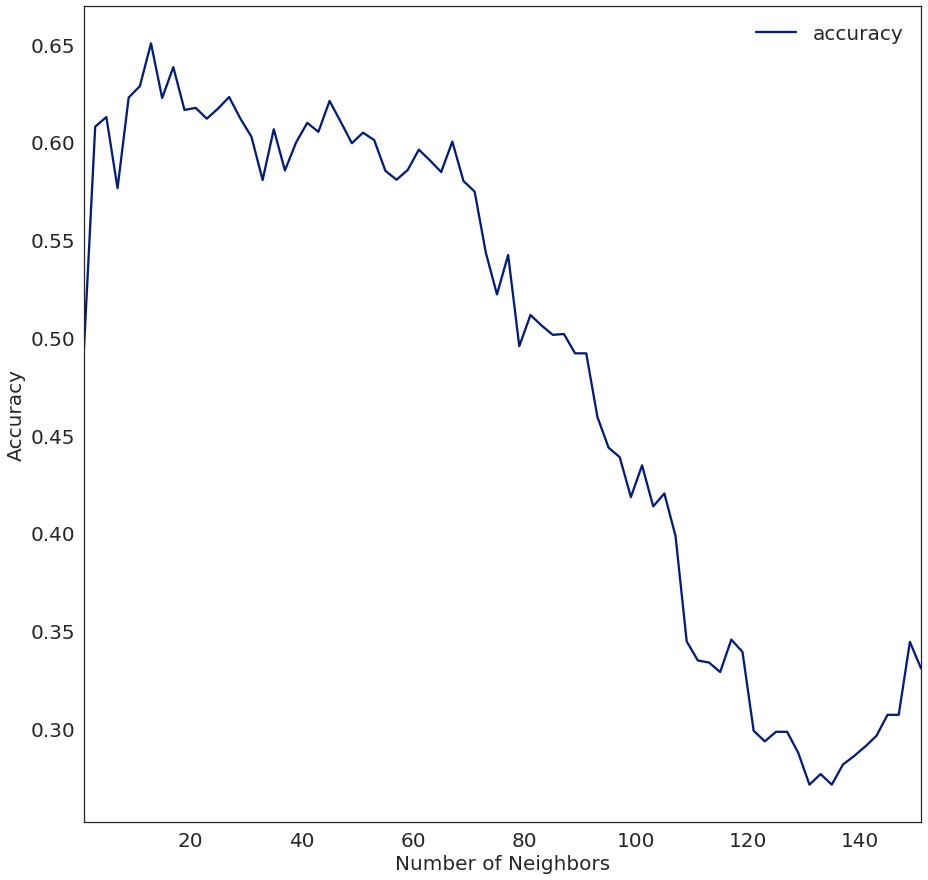

In [40]:
ax = k_scores.plot(figsize=(15, 15), fontsize=20)
ax.set_xlabel('Number of Neighbors', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
ax.legend(fontsize=20)

# Search for best k using iterative grid search

In [41]:
param_grid = {'n_neighbors': range(1, int(np.floor((X_train.shape[0]*0.8)-1)), 2)}

grid_knn = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    cv=5, 
                    scoring='accuracy')
grid_knn = grid_knn.fit(X_train, y_train)

grid_results = pd.DataFrame(list(zip(grid_knn.cv_results_['param_n_neighbors'].data,
                                     grid_knn.cv_results_['mean_test_score'])),
                             columns=['k', 'accuracy']).set_index('k')

print(grid_knn.best_params_, grid_knn.best_estimator_)

{'n_neighbors': 13} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')


# Search for best k using random grid search and include different weightings of the nearest neighbors

In [42]:
param_grid = {'n_neighbors': range(1, int(np.floor((X_train.shape[0]*0.8)-1)), 2), 'weights': ['uniform', 'distance']}

rand_knn = RandomizedSearchCV(KNeighborsClassifier(), 
                          param_grid, 
                          cv=5, 
                          scoring='accuracy',
                          n_iter=80)
rand_knn = rand_knn.fit(X_train, y_train)
rand_knn.cv_results_['mean_test_score']
print(rand_knn.best_estimator_, rand_knn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='distance') 0.661458333333


# Best KNN has k=13 nearest neighbors using uniform weighting.  Lets look at classification accuracy using the test data.

In [43]:
print(accuracy_score(y_test, rand_knn.best_estimator_.predict(X_test)))

0.674698795181


# Logistic Regression

In [44]:
logreg_l1 = LogisticRegressionCV(Cs=np.power(10.0, np.arange(-10, 10)),
                                 cv=5, 
                                 penalty='l1',  
                                 solver='liblinear', 
                                 random_state=666, 
                                 multi_class='ovr')

logreg_l2 = LogisticRegressionCV(Cs=np.power(10.0, np.arange(-10, 10)),
                                 cv=5, 
                                 penalty='l2',  
                                 solver='liblinear', 
                                 random_state=666, 
                                 multi_class='ovr')

logreg_l1.fit(X_train, y_train)
logreg_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=666, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

results from LogReg model using L1 regularization
Training Data Accuracy: 0.85
Test Data Accuracy:     0.66
Precision:              1.00
Recall:                 0.89
F1 Score:                 0.94




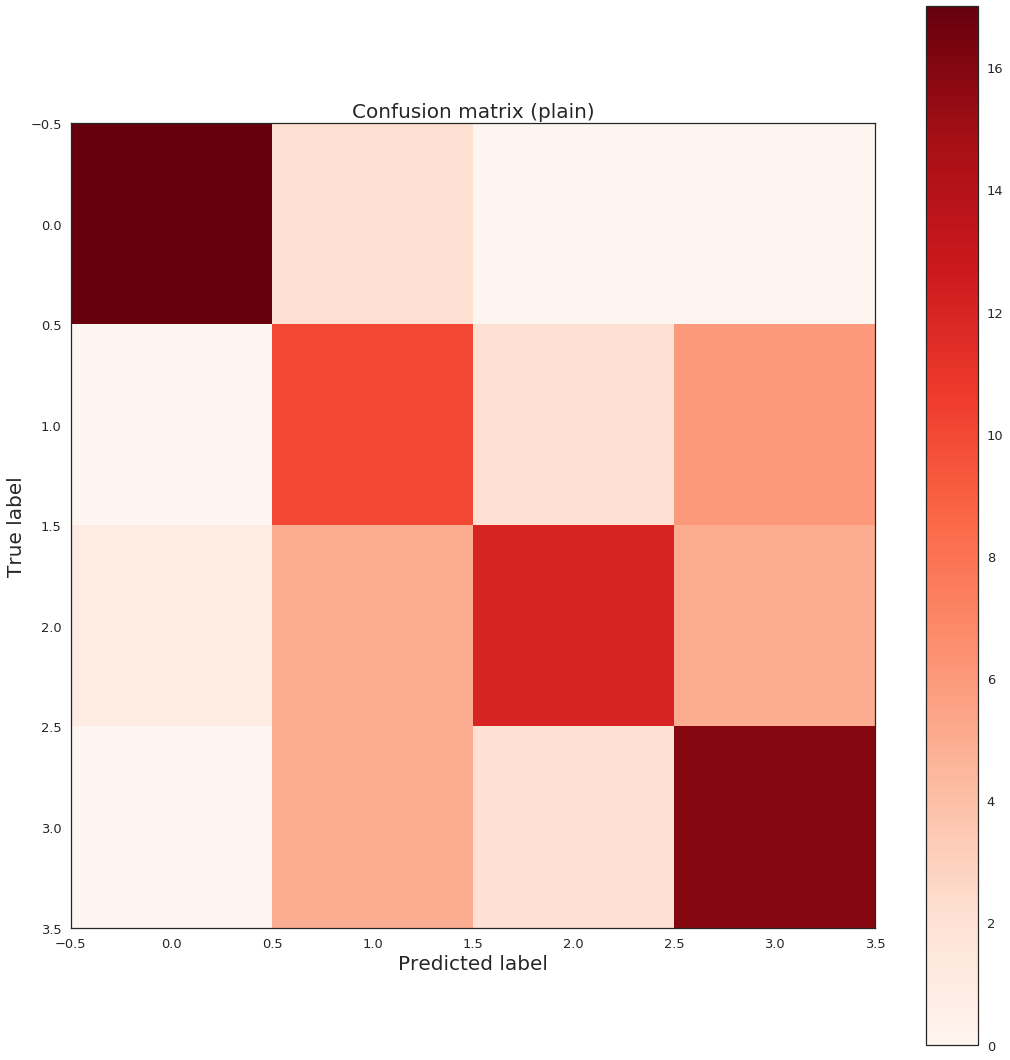

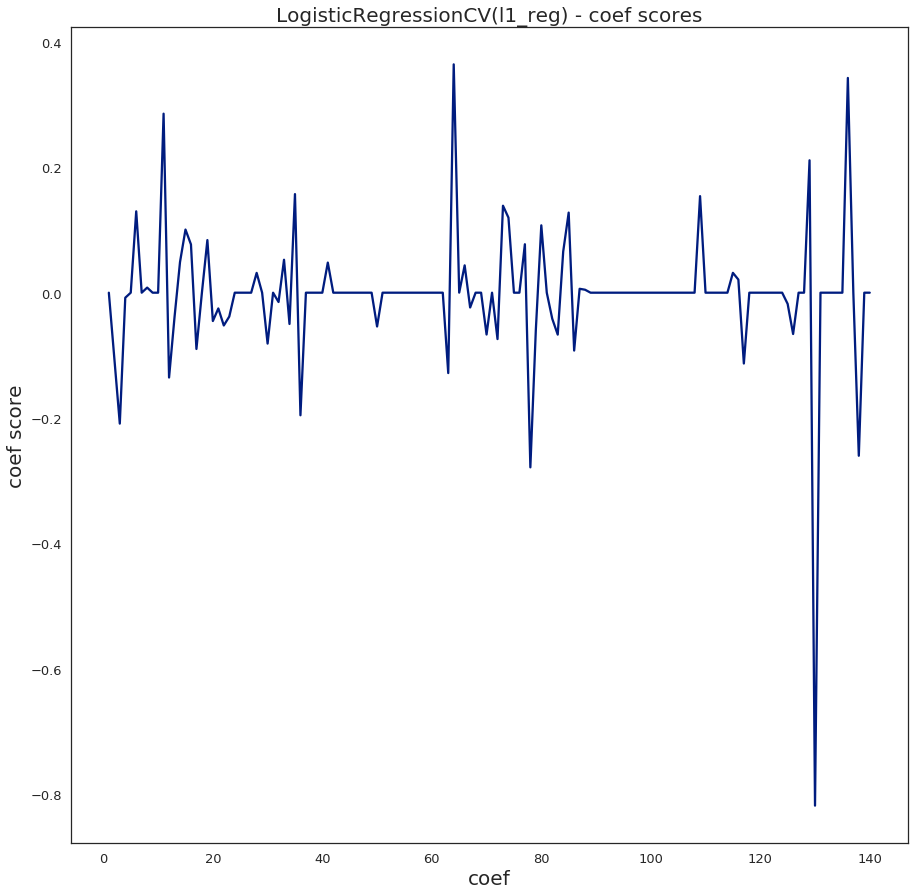

In [45]:
print('results from LogReg model using L1 regularization')
train_score(logreg_l1, X_train, X_test, y_train, y_test)
logreg_l1_y_pred = logreg_l1.predict(X_test)
labelname = logreg_l1.classes_
logreg_l1_conf = confusion_matrix(y_test, logreg_l1_y_pred, labels=labelname)
plot_confusion_matrix(logreg_l1_conf, title='Confusion matrix (plain)', cmap=plt.cm.Reds, labels=labelname)
plt.figure(figsize=(15, 15))
plt.plot(np.linspace(1, 140, 140), np.mean(logreg_l1.coef_, axis=0))
plt.title('LogisticRegressionCV(l1_reg) - coef scores', fontsize=20)
plt.ylabel('coef score', fontsize=20)
plt.xlabel('coef', fontsize=20)
plt.show()

results from LogReg model using L2 regularization
Training Data Accuracy: 0.92
Test Data Accuracy:     0.63
Precision:              0.94
Recall:                 0.89
F1 Score:                 0.91




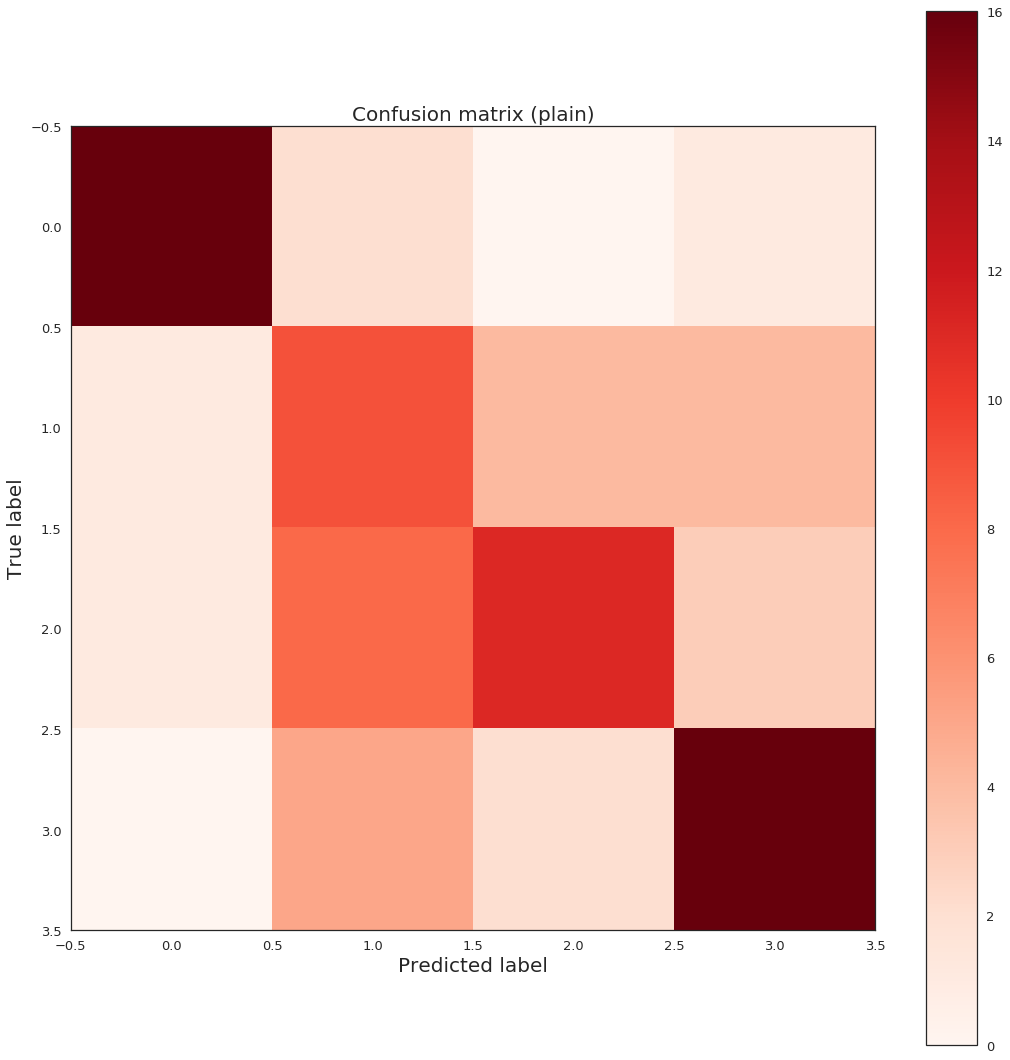

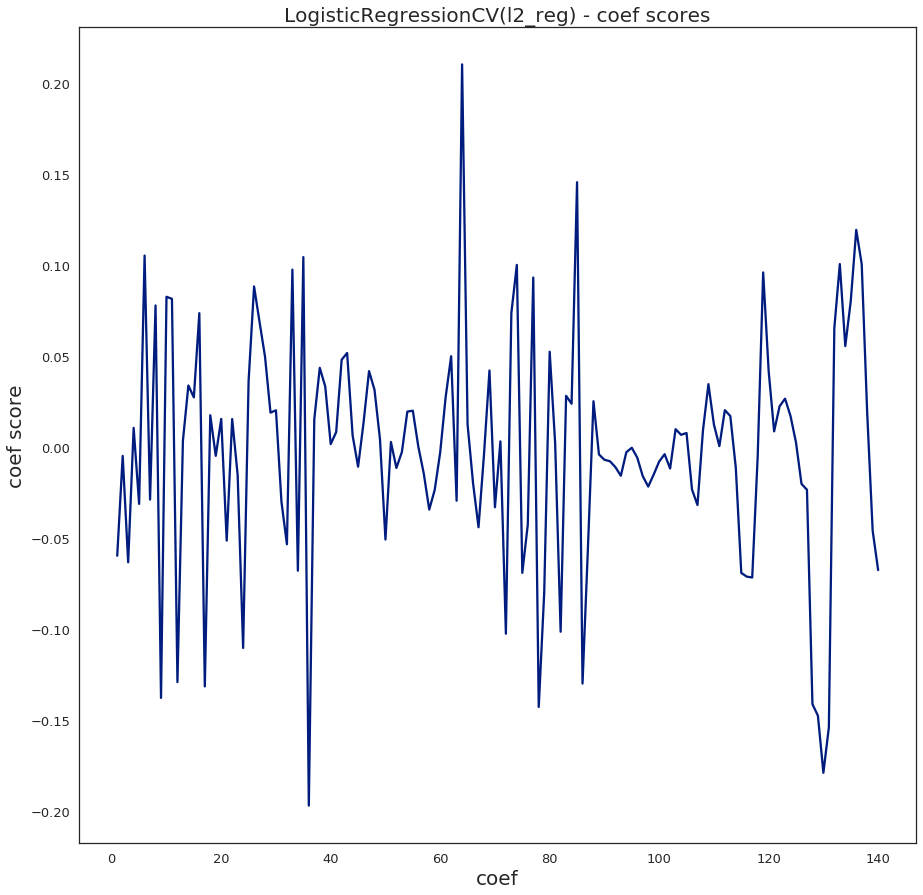

In [46]:
print('results from LogReg model using L2 regularization')
train_score(logreg_l2, X_train, X_test, y_train, y_test)
logreg_l2_y_pred = logreg_l2.predict(X_test)
labelname = logreg_l2.classes_
logreg_l2_conf = confusion_matrix(y_test, logreg_l2_y_pred, labels=labelname)
plot_confusion_matrix(logreg_l2_conf, title='Confusion matrix (plain)', cmap=plt.cm.Reds, labels=labelname)
plt.figure(figsize=(15, 15))
plt.plot(np.linspace(1, 140, 140), np.mean(logreg_l2.coef_, axis=0))
plt.title('LogisticRegressionCV(l2_reg) - coef scores', fontsize=20)
plt.ylabel('coef score', fontsize=20)
plt.xlabel('coef', fontsize=20)
plt.show()

# Naive Bayes (GNB)

In [47]:
# Gaussian Naive Bayes (GNB)
gnb = naive_bayes.GaussianNB()
gnb_acc_scores = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict((X_test))
print('GaussianNB')
print('GaussianNB accuracy scores: ', gnb_acc_scores, ' mean: ', np.mean(gnb_acc_scores))
print('GaussianNB classification report')
print(classification_report(y_test, gnb_y_pred))
print('GaussianNB training scores')
train_score(gnb, X_train, X_test, y_train, y_test)

GaussianNB
GaussianNB accuracy scores:  [ 0.6097561   0.575       0.62162162  0.7027027   0.54054054]  mean:  0.609924192485
GaussianNB classification report
             precision    recall  f1-score   support

    Hip_Hop       0.69      0.95      0.80        19
     breaks       0.21      0.17      0.19        18
        dnb       0.65      0.57      0.60        23
      house       0.61      0.61      0.61        23

avg / total       0.55      0.58      0.56        83

GaussianNB training scores
Training Data Accuracy: 0.67
Test Data Accuracy:     0.58
Precision:              0.75
Recall:                 0.95
F1 Score:                 0.84




In [48]:
# Bernoulli naive Bayes (BNB)
bnb = naive_bayes.BernoulliNB()
bnb_acc_scores = cross_val_score(bnb, X_train, y_train, cv=5, scoring='accuracy')
bnb.fit(X_train, y_train)
bnb_y_pred = bnb.predict((X_test))
print('BernoulliNB')
print('BernoulliNB accuracy scores: ', bnb_acc_scores, ' mean: ', np.mean(bnb_acc_scores))
print('BernoulliNB classification report')
print(classification_report(y_test, bnb_y_pred))
print('BernoulliNB training scores')
train_score(bnb, X_train, X_test, y_train, y_test)

BernoulliNB
BernoulliNB accuracy scores:  [ 0.56097561  0.6         0.56756757  0.62162162  0.48648649]  mean:  0.567330257086
BernoulliNB classification report
             precision    recall  f1-score   support

    Hip_Hop       0.68      0.89      0.77        19
     breaks       0.12      0.06      0.08        18
        dnb       0.61      0.61      0.61        23
      house       0.59      0.70      0.64        23

avg / total       0.52      0.58      0.54        83

BernoulliNB training scores
Training Data Accuracy: 0.60
Test Data Accuracy:     0.58
Precision:              0.74
Recall:                 0.94
F1 Score:                 0.83




# Singular vector machines (SVM): linear and non-linear

In [49]:
# linear SVM only
lin_svc = SVC(kernel='linear', probability=True)
lin_svc_acc_scores = cross_val_score(lin_svc, X_train, y_train, cv=5, scoring='accuracy')
lin_svc.fit(X_train, y_train)
print('Linear SVC')
print('Linear SVC accuracy scores: ', lin_svc_acc_scores, ' mean: ', np.mean(lin_svc_acc_scores))
train_score(lin_svc, X_train, X_test, y_train, y_test)

Linear SVC
Linear SVC accuracy scores:  [ 0.73170732  0.5         0.56756757  0.83783784  0.64864865]  mean:  0.657152274225
Training Data Accuracy: 1.00
Test Data Accuracy:     0.72
Precision:              0.94
Recall:                 0.84
F1 Score:                 0.89




In [50]:
# lets take a look at the several SVMs by doing a gridsearch using various kernels, including the linear kernel.  I will 
# also look at various penalty parameters
param_grid = {'C': [1.0, 10., 100., 1000., 100000., 1000000.],
                      'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_svc = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=5, scoring='accuracy')
grid_svc.fit(X_train, y_train)
grid_results_C = pd.DataFrame(list(zip(grid_svc.cv_results_['param_C'].data,
                                       grid_svc.cv_results_['param_kernel'].data,
                                     grid_svc.cv_results_['mean_test_score'])),
                             columns=['C', 'kernel', 'accuracy']).set_index('C')

print('Best parameters:\n', grid_svc.best_params_, grid_svc.best_estimator_)
print('\nResults')
print(grid_results_C)
print('\naccuracy:\n', accuracy_score(y_test, grid_svc.best_estimator_.predict(X_test)))

Best parameters:
 {'C': 10.0, 'kernel': 'rbf'} SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Results
            kernel  accuracy
C                           
1.0         linear  0.656250
1.0           poly  0.552083
1.0            rbf  0.671875
1.0        sigmoid  0.609375
10.0        linear  0.656250
10.0          poly  0.593750
10.0           rbf  0.708333
10.0       sigmoid  0.562500
100.0       linear  0.656250
100.0         poly  0.619792
100.0          rbf  0.708333
100.0      sigmoid  0.500000
1000.0      linear  0.656250
1000.0        poly  0.614583
1000.0         rbf  0.708333
1000.0     sigmoid  0.510417
100000.0    linear  0.656250
100000.0      poly  0.614583
100000.0       rbf  0.708333
100000.0   sigmoid  0.515625
1000000.0   linear  0.656250
1000000.0     poly  0.614583
1000000.0      rbf  0.70

# Decision tree classifier

In [51]:
dtc = DecisionTreeClassifier(criterion='gini')
dtc_acc_scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy')
dtc.fit(X_train, y_train)
print('dtc')
print('dtc accuracy scores: ', dtc_acc_scores, ' mean: ', np.mean(dtc_acc_scores))
train_score(dtc, X_train, X_test, y_train, y_test)

dtc
dtc accuracy scores:  [ 0.46341463  0.55        0.45945946  0.64864865  0.59459459]  mean:  0.54322346737
Training Data Accuracy: 1.00
Test Data Accuracy:     0.54
Precision:              0.88
Recall:                 0.93
F1 Score:                 0.90




# Random forrest classifier

In [52]:
rfc = RandomForestClassifier(criterion='gini')
rfc_acc_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
rfc.fit(X_train, y_train)
print('rfc')
train_score(rfc, X_train, X_test, y_train, y_test)

rfc
Training Data Accuracy: 0.97
Test Data Accuracy:     0.59
Precision:              0.89
Recall:                 0.89
F1 Score:                 0.89




# Now I will use the same algorithmsto look at sub-genre classification which I predict will be a much more difficult task as much of the structure contained in the music will have more similarities between groups.  Specifically, I will look at classifying drum and bass style electronic music into three sub-genre styles of drum and bass:

# Start with getting the processed tract data used for classification

In [53]:
# import data
savefile_master_ZCR_final = 'tracks_set_3_ZCR_final.pickle'
savefile_master_RMS_final = 'tracks_set_3_RMS_final.pickle'
savefile_master_SPEC_CENTR_final = 'tracks_set_3_SPEC_CENTR_final.pickle'
savefile_master_SPEC_ROLL_final = 'tracks_set_3_SPEC_ROLL_final.pickle'
savefile_master_SPEC_FLUX_final = 'tracks_set_3_SPEC_FLUX_final.pickle'
savefile_master_MFCC_final = 'tracks_set_3_MFCC_final.pickle'
savefile_master_RYTHM_final = 'tracks_set_3_RYTHM_final.pickle'

# create the various empty dataframes and dump data into them from file.
df = pd.DataFrame()
df_info = pd.DataFrame()
df_ZCR = pd.DataFrame()
df_RMS = pd.DataFrame()
df_SPEC_CENTR = pd.DataFrame()
df_SPEC_ROLL = pd.DataFrame()
df_SPEC_FLUX = pd.DataFrame()
df_MFCC = pd.DataFrame()
df_RYTHM = pd.DataFrame()


data_temp = open_dataframe_pickle(savefile_master_ZCR_final)

df_info['labels'] = data_temp['label']
df['labels'] = data_temp['label']
df_info['tracks'] = data_temp['path']
df_info['sample_rate'] = data_temp['sample_rate']

df_ZCR['ZCR'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_RMS_final)
df_RMS['RMS'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_SPEC_CENTR_final)
df_SPEC_CENTR['SPEC_CENTR'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_SPEC_ROLL_final)
df_SPEC_ROLL['SPEC_ROLL'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_SPEC_FLUX_final)
df_SPEC_FLUX['SPEC_FLUX'] = data_temp['data']

data_temp = open_dataframe_pickle(savefile_master_MFCC_final)
df_MFCC['MFCCs_mean_1'] = data_temp['MFCCs_mean_1']
df_MFCC['MFCCs_std_1'] = data_temp['MFCCs_std_1']
df_MFCC['mspec_mean_1'] = data_temp['mspec_mean_1']
df_MFCC['mspec_std_1'] = data_temp['mspec_std_1']
df_MFCC['MFCCs_mean_2'] = data_temp['MFCCs_mean_2']
df_MFCC['MFCCs_std_2'] = data_temp['MFCCs_std_2']
df_MFCC['mspec_mean_2'] = data_temp['mspec_mean_2']
df_MFCC['mspec_std_2'] = data_temp['mspec_std_2']
df_MFCC['spec_mean_2'] = data_temp['spec_mean_2']
df_MFCC['spec_std_2'] = data_temp['spec_std_2']


data_temp = open_dataframe_pickle(savefile_master_RYTHM_final)
df_RYTHM['SSD'] = data_temp['SSD']
df_RYTHM['RP'] = data_temp['RP']
df_RYTHM['RH'] = data_temp['RH']

del data_temp

mean_temp = []
std_temp = []
for current in df_ZCR['ZCR']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['ZCR_mean'] = mean_temp
df['ZCR_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_RMS['RMS']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['RMS_mean'] = mean_temp
df['RMS_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_SPEC_CENTR['SPEC_CENTR']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['SPEC_CENTR_mean'] = mean_temp
df['SPEC_CENTR_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_SPEC_ROLL['SPEC_ROLL']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['SPEC_ROLL_mean'] = mean_temp
df['SPEC_ROLL_std'] = std_temp

mean_temp = []
std_temp = []
for current in df_SPEC_FLUX['SPEC_FLUX']:
    mean_temp.append(np.mean(current))
    std_temp.append(np.std(current))

df['SPEC_FLUX_mean'] = mean_temp
df['SPEC_FLUX_std'] = std_temp

# Place the processed data into dataframes to train the various models

In [54]:
index = np.linspace(0, df.shape[0]-1, df.shape[0], dtype=np.int)
columns = (['MFCC_mean_01_1', 'MFCC_mean_02_1', 'MFCC_mean_03_1', 'MFCC_mean_04_1', 'MFCC_mean_05_1', 'MFCC_mean_06_1',
            'MFCC_mean_07_1', 'MFCC_mean_08_1', 'MFCC_mean_09_1', 'MFCC_mean_10_1', 'MFCC_mean_11_1', 'MFCC_mean_12_1',
            'MFCC_mean_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_mean_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)


columns = (['MFCC_std_01_1', 'MFCC_std_02_1', 'MFCC_std_03_1', 'MFCC_std_04_1', 'MFCC_std_05_1', 'MFCC_std_06_1',
            'MFCC_std_07_1', 'MFCC_std_08_1', 'MFCC_std_09_1', 'MFCC_std_10_1', 'MFCC_std_11_1', 'MFCC_std_12_1',
            'MFCC_std_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_std_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_mean_01_1', 'mspec_mean_02_1', 'mspec_mean_03_1', 'mspec_mean_04_1', 'mspec_mean_05_1', 'mspec_mean_06_1',
            'mspec_mean_07_1', 'mspec_mean_08_1', 'mspec_mean_09_1', 'mspec_mean_10_1', 'mspec_mean_11_1', 'mspec_mean_12_1',
            'mspec_mean_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_mean_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_std_01_1', 'mspec_std_02_1', 'mspec_std_03_1', 'mspec_std_04_1', 'mspec_std_05_1', 'mspec_std_06_1',
            'mspec_std_07_1', 'mspec_std_08_1', 'mspec_std_09_1', 'mspec_std_10_1', 'mspec_std_11_1', 'mspec_std_12_1',
            'mspec_std_13_1'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_std_1']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['MFCCs_mean_01_2', 'MFCCs_mean_02_2', 'MFCCs_mean_03_2', 'MFCCs_mean_04_2', 'MFCCs_mean_05_2', 'MFCCs_mean_06_2',
            'MFCCs_mean_07_2', 'MFCCs_mean_08_2', 'MFCCs_mean_09_2', 'MFCCs_mean_10_2', 'MFCCs_mean_11_2', 'MFCCs_mean_12_2',
            'MFCCs_mean_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_mean_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['MFCCs_std_01_2', 'MFCCs_std_02_2', 'MFCCs_std_03_2', 'MFCCs_std_04_2', 'MFCCs_std_05_2', 'MFCCs_std_06_2',
            'MFCCs_std_07_2', 'MFCCs_std_08_2', 'MFCCs_std_09_2', 'MFCCs_std_10_2', 'MFCCs_std_11_2', 'MFCCs_std_12_2',
            'MFCCs_std_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['MFCCs_std_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_mean_01_2', 'mspec_mean_02_2', 'mspec_mean_03_2', 'mspec_mean_04_2', 'mspec_mean_05_2', 'mspec_mean_06_2',
            'mspec_mean_07_2', 'mspec_mean_08_2', 'mspec_mean_09_2', 'mspec_mean_10_2', 'mspec_mean_11_2', 'mspec_mean_12_2',
            'mspec_mean_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_mean_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['mspec_std_01_2', 'mspec_std_02_2', 'mspec_std_03_2', 'mspec_std_04_2', 'mspec_std_05_2', 'mspec_std_06_2',
            'mspec_std_07_2', 'mspec_std_08_2', 'mspec_std_09_2', 'mspec_std_10_2', 'mspec_std_11_2', 'mspec_std_12_2',
            'mspec_std_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['mspec_std_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['spec_mean_01_2', 'spec_mean_02_2', 'spec_mean_03_2', 'spec_mean_04_2', 'spec_mean_05_2', 'spec_mean_06_2',
            'spec_mean_07_2', 'spec_mean_08_2', 'spec_mean_09_2', 'spec_mean_10_2', 'spec_mean_11_2', 'spec_mean_12_2',
            'spec_mean_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['spec_mean_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

columns = (['spec_std_01_2', 'spec_std_02_2', 'spec_std_03_2', 'spec_std_04_2', 'spec_std_05_2', 'spec_std_06_2',
            'spec_std_07_2', 'spec_std_08_2', 'spec_std_09_2', 'spec_std_10_2', 'spec_std_11_2', 'spec_std_12_2',
            'spec_std_13_2'])
df_temp = pd.DataFrame(columns=columns, index=index)
for i, current in enumerate(df_MFCC['spec_std_2']):
    # temp_list = pd.Series(current)
    temp_list = dict(zip(columns, pd.Series(current)))
    df_temp.iloc[i] = temp_list

df = pd.concat([df, df_temp], axis=1)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

label_vector = df['labels']
df = df.drop('labels', 1)

# some classifiers require scaled data
df_scaled = scale(df)

# K nearest neighbor (KNN)

# Search for best k using random grid search and include different weightings of the nearest neighbors

In [55]:
# scaling is a requirement for knn
X_train, X_test, y_train, y_test = train_test_split(df_scaled, label_vector, test_size=.30, random_state=4444)

param_grid = {'n_neighbors': range(1, int(np.floor((X_train.shape[0]*0.8)-1)), 2), 'weights': ['uniform', 'distance']}

rand_knn = RandomizedSearchCV(KNeighborsClassifier(), 
                          param_grid, 
                          cv=5, 
                          scoring='accuracy',
                          n_iter=80)
rand_knn = rand_knn.fit(X_train, y_train)
rand_knn.cv_results_['mean_test_score']
print(rand_knn.best_estimator_, rand_knn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform') 0.655844155844


# Best KNN has k=9 nearest neighbors using uniform weighting.  Lets look at classification accuracy using the test data.

In [56]:
print(accuracy_score(y_test, rand_knn.best_estimator_.predict(X_test)))

0.712121212121


# Logistic Regression

In [57]:
logreg_l1 = LogisticRegressionCV(Cs=np.power(10.0, np.arange(-10, 10)),
                                 cv=5, 
                                 penalty='l1',  
                                 solver='liblinear', 
                                 random_state=666, 
                                 multi_class='ovr')

logreg_l2 = LogisticRegressionCV(Cs=np.power(10.0, np.arange(-10, 10)),
                                 cv=5, 
                                 penalty='l2',  
                                 solver='liblinear', 
                                 random_state=666, 
                                 multi_class='ovr')

logreg_l1.fit(X_train, y_train)
logreg_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=666, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

results from LogReg model using L1 regularization
Training Data Accuracy: 0.64
Test Data Accuracy:     0.59
Precision:              0.93
Recall:                 0.67
F1 Score:                 0.78




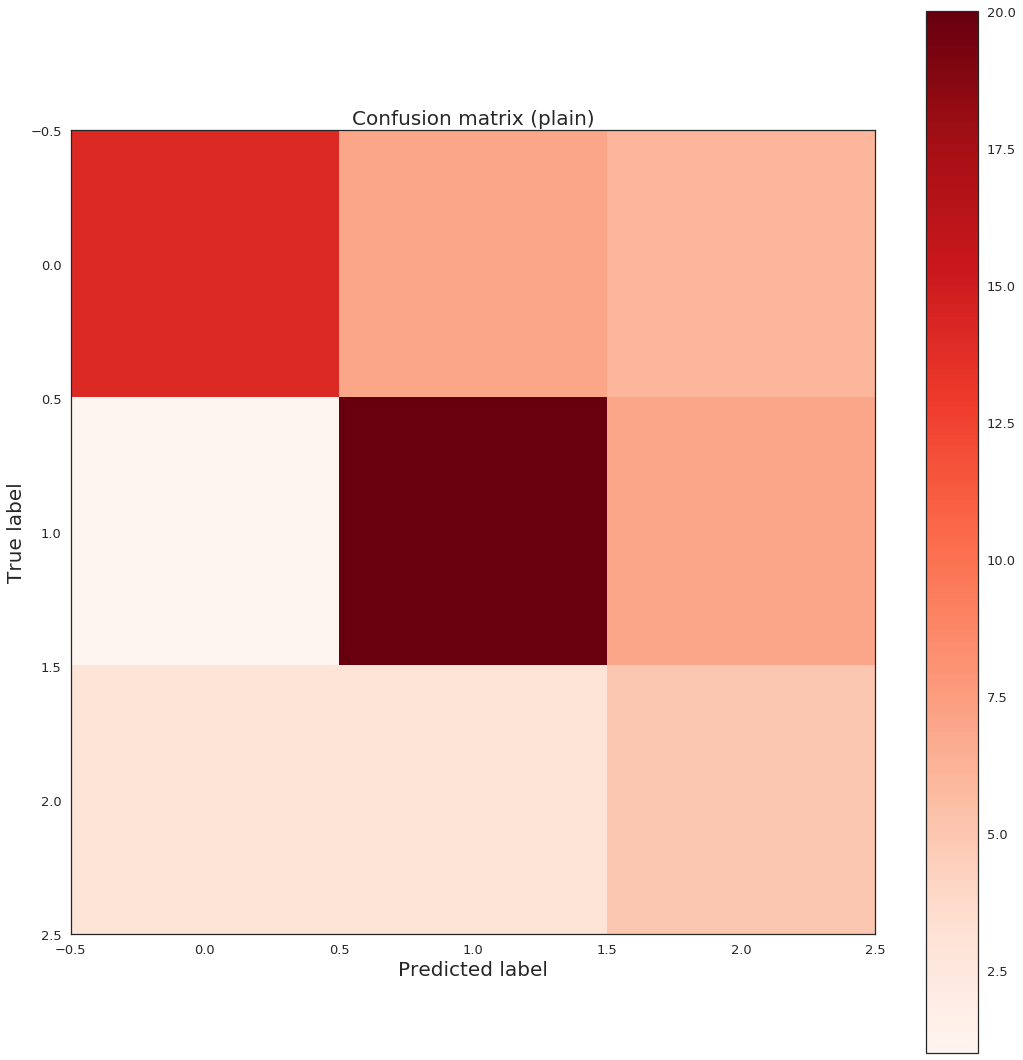

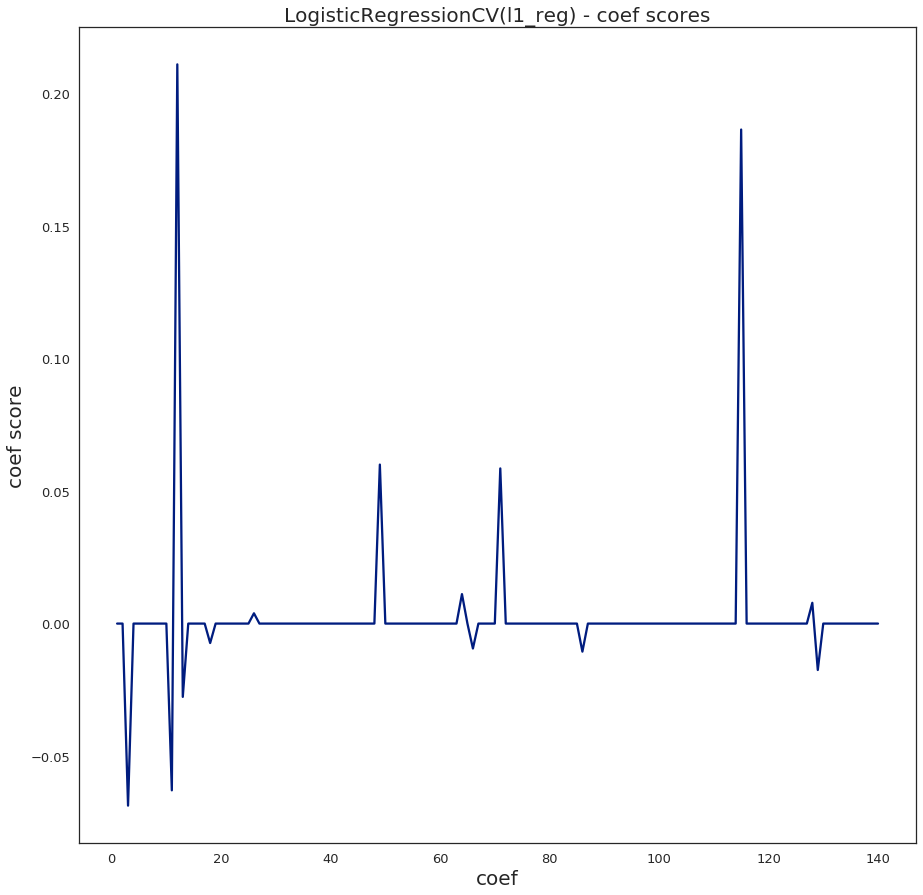

In [58]:
print('results from LogReg model using L1 regularization')
train_score(logreg_l1, X_train, X_test, y_train, y_test)
logreg_l1_y_pred = logreg_l1.predict(X_test)
labelname = logreg_l1.classes_
logreg_l1_conf = confusion_matrix(y_test, logreg_l1_y_pred, labels=labelname)
plot_confusion_matrix(logreg_l1_conf, title='Confusion matrix (plain)', cmap=plt.cm.Reds, labels=labelname)
plt.figure(figsize=(15, 15))
plt.plot(np.linspace(1, 140, 140), np.mean(logreg_l1.coef_, axis=0))
plt.title('LogisticRegressionCV(l1_reg) - coef scores', fontsize=20)
plt.ylabel('coef score', fontsize=20)
plt.xlabel('coef', fontsize=20)
plt.show()

results from LogReg model using L2 regularization
Training Data Accuracy: 0.82
Test Data Accuracy:     0.67
Precision:              0.84
Recall:                 0.64
F1 Score:                 0.73




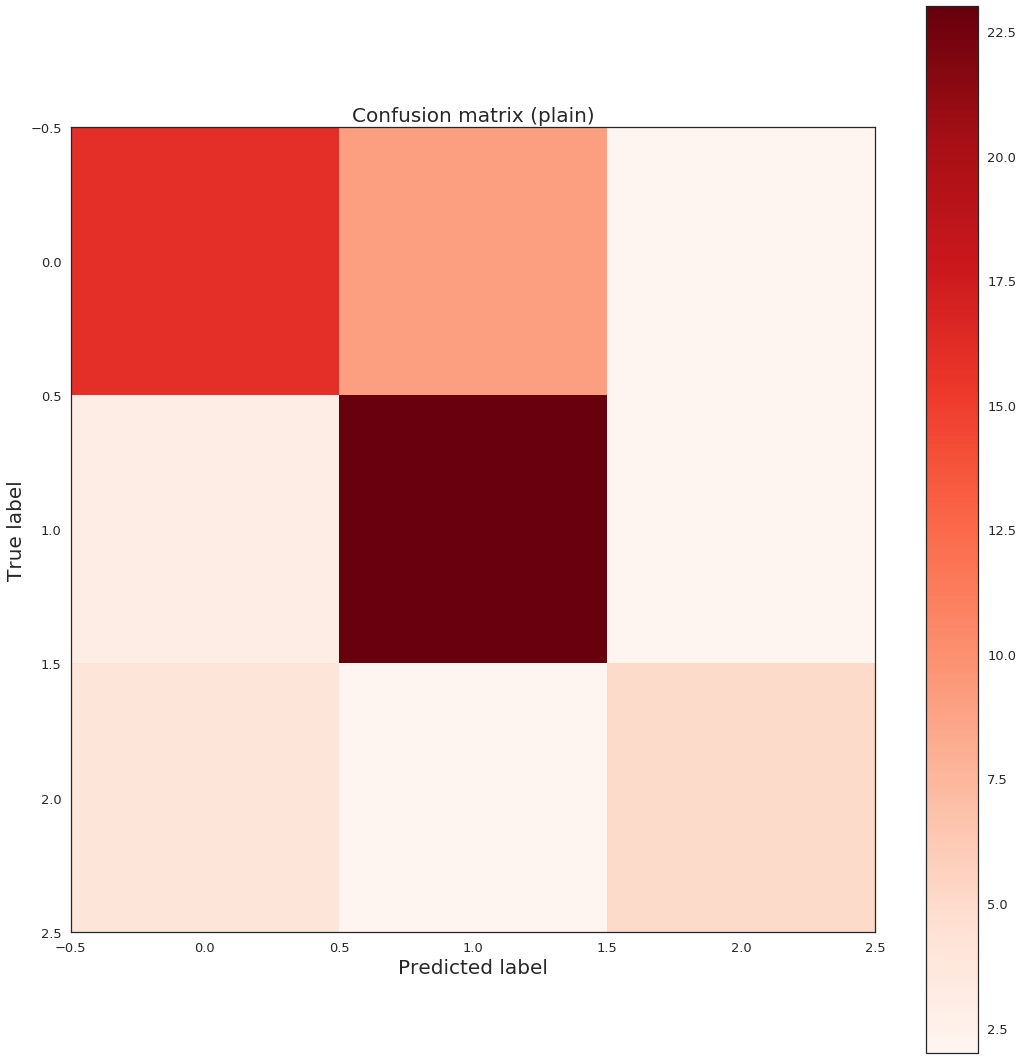

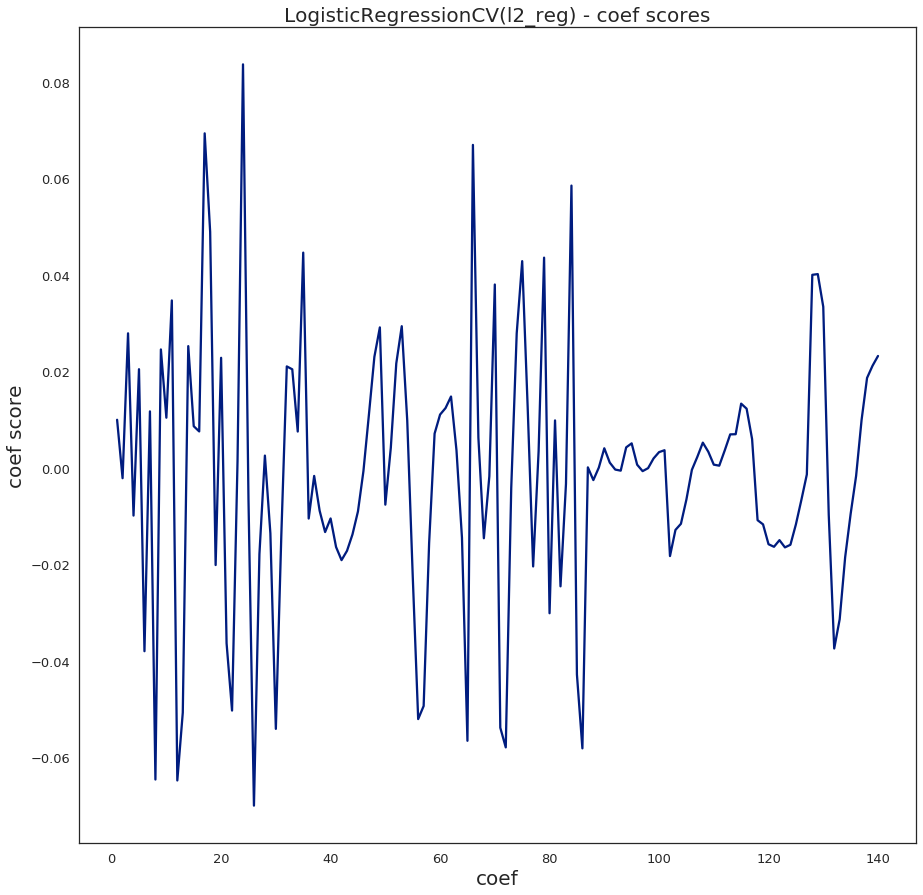

In [59]:
print('results from LogReg model using L2 regularization')
train_score(logreg_l2, X_train, X_test, y_train, y_test)
logreg_l2_y_pred = logreg_l2.predict(X_test)
labelname = logreg_l2.classes_
logreg_l2_conf = confusion_matrix(y_test, logreg_l2_y_pred, labels=labelname)
plot_confusion_matrix(logreg_l2_conf, title='Confusion matrix (plain)', cmap=plt.cm.Reds, labels=labelname)
plt.figure(figsize=(15, 15))
plt.plot(np.linspace(1, 140, 140), np.mean(logreg_l2.coef_, axis=0))
plt.title('LogisticRegressionCV(l2_reg) - coef scores', fontsize=20)
plt.ylabel('coef score', fontsize=20)
plt.xlabel('coef', fontsize=20)
plt.show()

# Naive Bayes (GNB)

In [60]:
# Gaussian naive Bayes (GNB)
gnb = naive_bayes.GaussianNB()
gnb_acc_scores = cross_val_score(gnb, X_train, y_train, cv=5, scoring='accuracy')
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict((X_test))
print('GaussianNB')
print('GaussianNB accuracy scores: ', gnb_acc_scores, ' mean: ', np.mean(gnb_acc_scores))
print('GaussianNB classification report')
print(classification_report(y_test, gnb_y_pred))
print('GaussianNB training scores')
train_score(gnb, X_train, X_test, y_train, y_test)

GaussianNB
GaussianNB accuracy scores:  [ 0.5625      0.65625     0.41935484  0.66666667  0.5862069 ]  mean:  0.578195680386
GaussianNB classification report
             precision    recall  f1-score   support

    dnb_big       0.77      0.63      0.69        27
  dnb_chill       0.70      0.57      0.63        28
 dnb_jungle       0.24      0.45      0.31        11

avg / total       0.65      0.58      0.60        66

GaussianNB training scores
Training Data Accuracy: 0.59
Test Data Accuracy:     0.58
Precision:              0.89
Recall:                 0.81
F1 Score:                 0.85




In [61]:
# Bernoulli naive Bayes (BNB)
bnb = naive_bayes.BernoulliNB()
bnb_acc_scores = cross_val_score(bnb, X_train, y_train, cv=5, scoring='accuracy')
bnb.fit(X_train, y_train)
bnb_y_pred = bnb.predict((X_test))
print('BernoulliNB')
print('BernoulliNB accuracy scores: ', bnb_acc_scores, ' mean: ', np.mean(bnb_acc_scores))
print('BernoulliNB classification report')
print(classification_report(y_test, bnb_y_pred))
print('BernoulliNB training scores')
train_score(bnb, X_train, X_test, y_train, y_test)

BernoulliNB
BernoulliNB accuracy scores:  [ 0.5625      0.59375     0.5483871   0.63333333  0.62068966]  mean:  0.591732017056
BernoulliNB classification report
             precision    recall  f1-score   support

    dnb_big       0.68      0.70      0.69        27
  dnb_chill       0.64      0.57      0.60        28
 dnb_jungle       0.31      0.36      0.33        11

avg / total       0.60      0.59      0.59        66

BernoulliNB training scores
Training Data Accuracy: 0.62
Test Data Accuracy:     0.59
Precision:              0.76
Recall:                 0.79
F1 Score:                 0.78




# Singular vector machines (SVM): linear and non-linear

In [62]:
# lets take a look at the several SVMs by doing a gridsearch using various kernels, including the linear kernel.  I will 
# also look at various penalty parameters
param_grid = {'C': [1.0, 10., 100., 1000., 100000., 1000000.],
                      'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_svc = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=5, scoring='accuracy')
grid_svc.fit(X_train, y_train)
grid_results_C = pd.DataFrame(list(zip(grid_svc.cv_results_['param_C'].data,
                                       grid_svc.cv_results_['param_kernel'].data,
                                     grid_svc.cv_results_['mean_test_score'])),
                             columns=['C', 'kernel', 'accuracy']).set_index('C')

print('Best parameters:\n', grid_svc.best_params_, grid_svc.best_estimator_)
print('\nResults')
print(grid_results_C)
print('\naccuracy:\n', accuracy_score(y_test, grid_svc.best_estimator_.predict(X_test)))

Best parameters:
 {'C': 1.0, 'kernel': 'rbf'} SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Results
            kernel  accuracy
C                           
1.0         linear  0.519481
1.0           poly  0.590909
1.0            rbf  0.655844
1.0        sigmoid  0.649351
10.0        linear  0.519481
10.0          poly  0.610390
10.0           rbf  0.649351
10.0       sigmoid  0.558442
100.0       linear  0.519481
100.0         poly  0.603896
100.0          rbf  0.649351
100.0      sigmoid  0.545455
1000.0      linear  0.519481
1000.0        poly  0.603896
1000.0         rbf  0.649351
1000.0     sigmoid  0.538961
100000.0    linear  0.519481
100000.0      poly  0.603896
100000.0       rbf  0.649351
100000.0   sigmoid  0.558442
1000000.0   linear  0.519481
1000000.0     poly  0.603896
1000000.0      rbf  0.6493

# Decision tree classifier

In [63]:
dtc = DecisionTreeClassifier(criterion='gini')
dtc_acc_scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy')
dtc.fit(X_train, y_train)
print('dtc')
print('dtc accuracy scores: ', dtc_acc_scores, ' mean: ', np.mean(dtc_acc_scores))
train_score(dtc, X_train, X_test, y_train, y_test)

dtc
dtc accuracy scores:  [ 0.59375     0.6875      0.35483871  0.6         0.51724138]  mean:  0.550666017798
Training Data Accuracy: 1.00
Test Data Accuracy:     0.62
Precision:              0.81
Recall:                 0.74
F1 Score:                 0.77




# Random forrest classifier

In [64]:
rfc = RandomForestClassifier(criterion='gini')
rfc_acc_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
rfc.fit(X_train, y_train)
print('rfc')
train_score(rfc, X_train, X_test, y_train, y_test)

rfc
Training Data Accuracy: 0.97
Test Data Accuracy:     0.55
Precision:              0.73
Recall:                 0.48
F1 Score:                 0.58


